# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from datetime import datetime as dt, timedelta
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns; sns.set()  # for plot styling
from sklearn.pipeline import Pipeline
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.ensemble import RandomForestClassifier
import xgboost as xg
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

/home/serena/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dataset

In [6]:
#Read the file and create dataset
filepath = 'income_evaluation.csv'
dataset = pd.read_csv(filepath, encoding='ISO_8859-1')

#trim whitespace from al columns
df_obj = dataset.select_dtypes(['object'])
dataset[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

#Finding and deleting all unknown values

occupation = int(dataset.occupation[dataset.loc[dataset.occupation == '?'].index].count())
workclass = int(dataset.workclass[dataset.loc[dataset.workclass == '?'].index].count())
country = int(dataset['native-country'][dataset.loc[dataset['native-country'] == '?'].index].count())

print("Droping " + str(occupation) + " records from occupation column")
print("Droping " + str(workclass) + " records from workclass column")
print("Droping " + str(country) + " records from native-country column")
before = dataset.shape[0]
print(before)
#drop the records that have a question mark (?) on one of the columns
dataset.drop(dataset.loc[dataset['native-country'] == '?'].index,inplace=True)
dataset.drop(dataset.loc[dataset['workclass'] == '?'].index,inplace=True)
dataset.drop(dataset.loc[dataset['occupation'] == '?'].index,inplace=True)


# post_dataset = overview_dataset(dataset) 
after = dataset.shape[0]
print(after)
print("Dropped about " + str(round(100 * (before-after)/before,2)) + "% of the records of the dataset")
# post_dataset


Droping 1843 records from occupation column
Droping 1836 records from workclass column
Droping 583 records from native-country column
32561
30162
Dropped about 7.37% of the records of the dataset


# Categorical and Numeric Data

In [7]:
#Encode all categorical data with OneHotEncoding
import category_encoders as ce

#education: the highest level of education achieved by an individual and
#education-num: the highest level of education achieved in numerical form.
#drop the education column and we only use the education-num column 

dataframe = dataset.copy()
dataframe = dataframe.drop(['education'], axis=1)
encoder = ce.OneHotEncoder(cols=['workclass', 'marital-status', 'occupation', 'relationship', 
                                 'race', 'sex', 'native-country'])
dataframe = encoder.fit_transform(dataframe)



In [8]:
#Label Encoding for income column
from sklearn import preprocessing

label_encoding = preprocessing.LabelEncoder()
dataframe.income = label_encoding.fit_transform(dataframe.income)


# Scaling Data

In [9]:
#Split data into training and testing 80-20

from sklearn.model_selection import train_test_split

X = dataframe.drop(['income'], axis = 1)
y = dataframe['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)



#We use RobustScaler if we have outliers and we want to reduce their influence

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
columns = X_train.columns

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=[columns])

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=[columns])


In [12]:
def plot_roc_auc(y_train, y_test, train_score, test_score):

    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve

    #predicted_test=gbm.predict_proba(X_test)[:, 1]
    #predicted_train=gbm.predict_proba(X_train)[:, 1]

    roc_auc_test = roc_auc_score(y_test, test_score)
    roc_auc_train = roc_auc_score(y_train, train_score)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_score)
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_score)

    plt.figure(figsize=(12,5))

    plt.plot(fpr_test, tpr_test, label='Light GBM test (area = %0.2f)' % roc_auc_test)
    plt.plot(fpr_train, tpr_train, label='Light GBM train (area = %0.2f)' % roc_auc_train)

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()


# Logistic Regression

In [33]:
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)
print(logreg_cv.best_estimator_)

/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.85
[[4195  312]
 [ 621  905]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4507
           1       0.74      0.59      0.66      1526

    accuracy                           0.85      6033
   macro avg       0.81      0.76      0.78      6033
weighted avg       0.84      0.85      0.84      6033



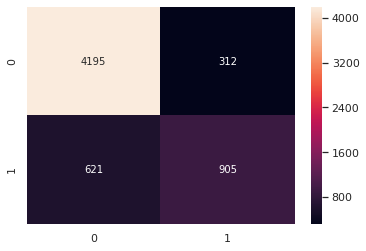

In [34]:
#Logistic Regression with GridSearch parameters

logreg = LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
logreg.fit(X_train, y_train)
prediction = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

print(confusion_matrix(y_test,prediction))
print(classification_report(y_test,prediction))

sns.heatmap(confusion_matrix(y_test,prediction),annot=True, fmt="d")

/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.84
[[4195  312]
 [ 625  901]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4507
           1       0.74      0.59      0.66      1526

    accuracy                           0.84      6033
   macro avg       0.81      0.76      0.78      6033
weighted avg       0.84      0.84      0.84      6033



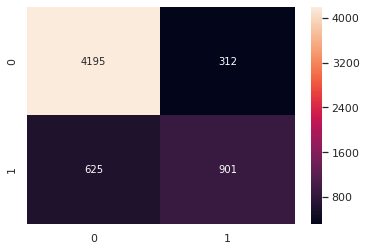

In [10]:

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
prediction = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

print(confusion_matrix(y_test,prediction))
print(classification_report(y_test,prediction))

sns.heatmap(confusion_matrix(y_test,prediction),annot=True, fmt="d")


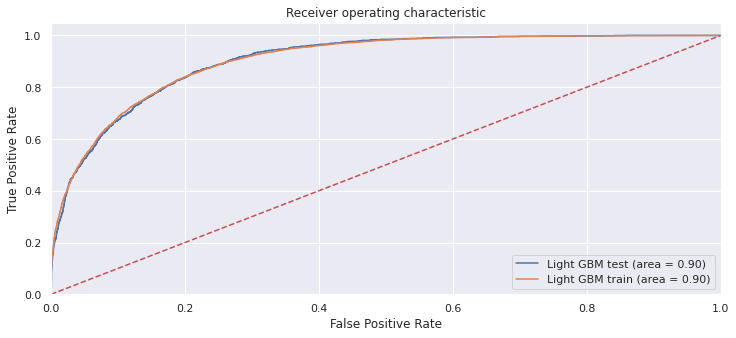

In [35]:
logreg_train = logreg.predict_proba(X_train)
logreg_train = logreg_train[:, 1]

logreg_test = logreg.predict_proba(X_test)
logreg_test = logreg_test[:, 1]

# y_test
plot_roc_auc(y_train, y_test,logreg_train,logreg_test )

/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


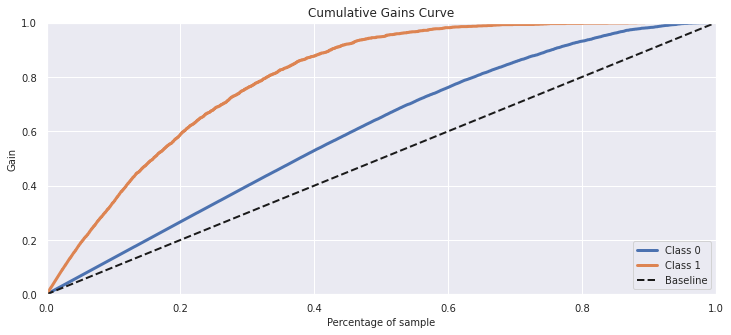

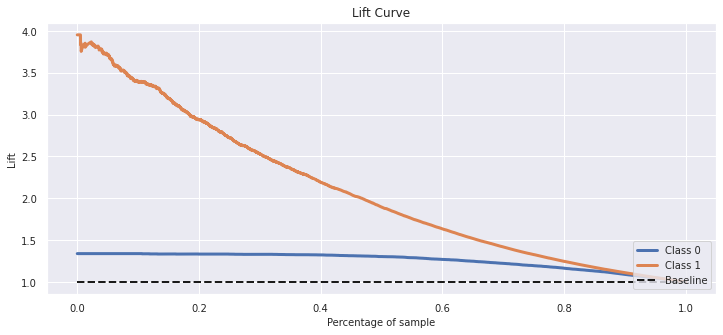

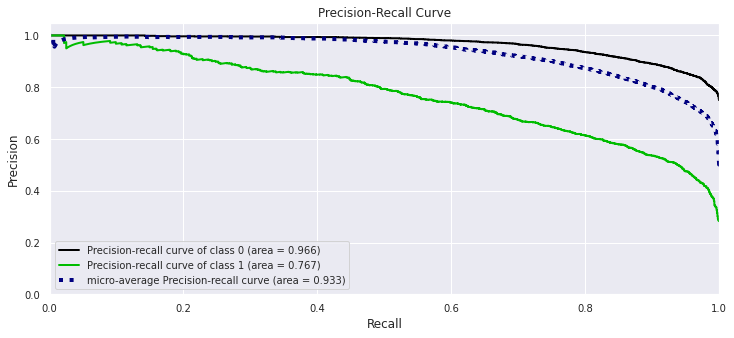

In [36]:
#Cumulative Gains Chart

import scikitplot as skplt
logreg_test = logreg.predict_proba(X_test)

skplt.metrics.plot_cumulative_gain(y_test, logreg_test, figsize=(12,5))
skplt.metrics.plot_lift_curve(y_test, logreg_test, figsize=(12,5))

skplt.metrics.plot_precision_recall_curve(y_test, logreg_test, figsize=(12,5))

# Random Forest

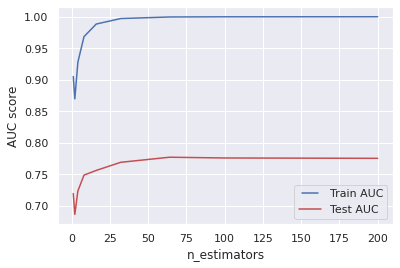

In [48]:
from sklearn.metrics import roc_curve, auc
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-pa

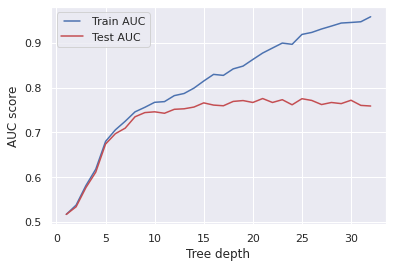

In [53]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/serena/anaconda3/lib/python3.7/site-pa

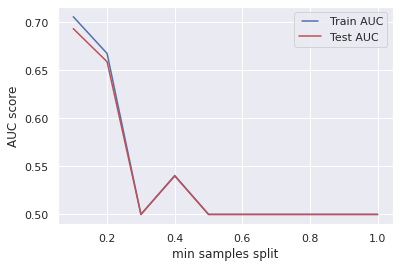

In [56]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

Accuracy for rbf RandomForestClassifier is  0.8470081219956904
[[4331  176]
 [ 747  779]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4507
           1       0.82      0.51      0.63      1526

    accuracy                           0.85      6033
   macro avg       0.83      0.74      0.77      6033
weighted avg       0.84      0.85      0.83      6033



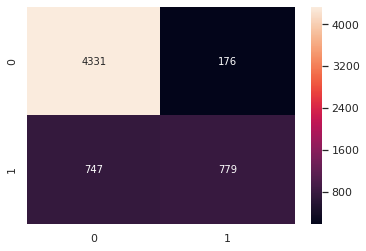

In [50]:
#RFC with the parameters from GridSearchCV
rfc = RandomForestClassifier(criterion = 'gini', max_depth= 8, max_features = 'auto', n_estimators = 500)

rfc.fit(X_train, y_train)
prediction = rfc.predict(X_test)

print('Accuracy for rbf RandomForestClassifier is ',metrics.accuracy_score(prediction,y_test))
print(confusion_matrix(y_test,prediction))
print(classification_report(y_test,prediction))

sns.heatmap(confusion_matrix(y_test,prediction),annot=True, fmt="d")

In [61]:
# Prediction using a new dataset
# Create a function that handles the predictions

def predict_something(dataset):
    
#     dataset.drop(dataset.loc[dataset['native-country'] == '?'].index,inplace=True)
#     dataset.drop(dataset.loc[dataset['workclass'] == '?'].index,inplace=True)
#     dataset.drop(dataset.loc[dataset['occupation'] == '?'].index,inplace=True)

    dataset = dataset.drop(['education','income'], axis=1)
    encoder = ce.OneHotEncoder(cols=['workclass', 'marital-status', 'occupation', 'relationship', 
                                     'race', 'sex', 'native-country'])
    dataset = encoder.fit_transform(dataset)
    return dataset

In [63]:
filepath = '/home/serena/Downloads/Predicting-US-Census-Income-master/Dataset/adult-training.csv'
dataset = pd.read_csv(filepath, encoding='ISO_8859-1')
dataframe = predict_something(dataset)
income = dataset.income
prediction = rfc.predict(dataframe)

print('Accuracy for rbf RandomForestClassifier is ',metrics.accuracy_score(prediction,income))

ValueError: Number of features of the model must match the input. Model n_features is 88 and input n_features is 92 

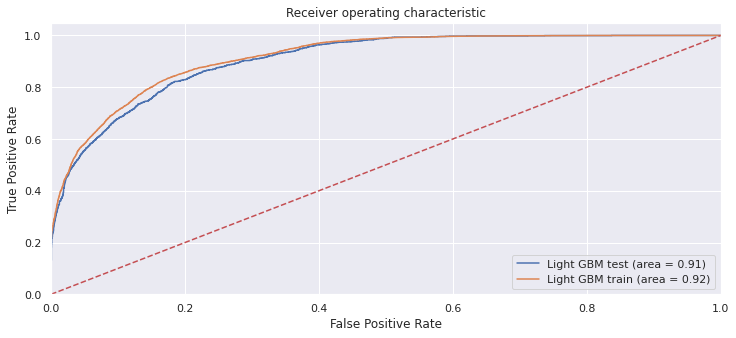

In [18]:
rfc_probs_train = rfc.predict_proba(X_train)
rfc_probs_train = rfc_probs_train[:, 1]

rfc_probs = rfc.predict_proba(X_test)
rfc_probs = rfc_probs[:, 1]

# y_test
plot_roc_auc(y_train, y_test,rfc_probs_train,rfc_probs )

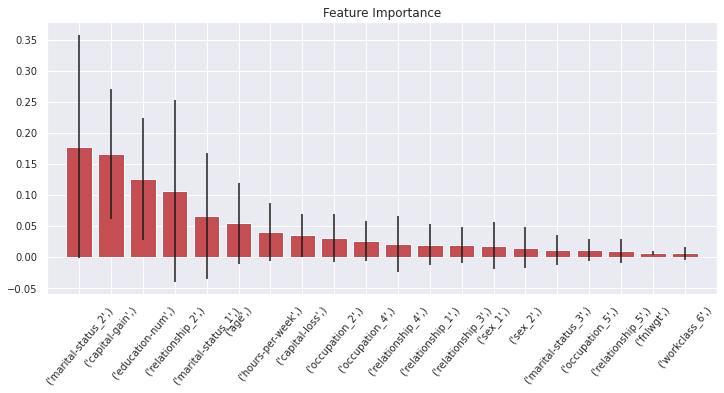

In [19]:
skplt.estimators.plot_feature_importances(
    rfc, 
    feature_names=X_test.columns, 
    figsize=(12,5), 
    x_tick_rotation=50
)

/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


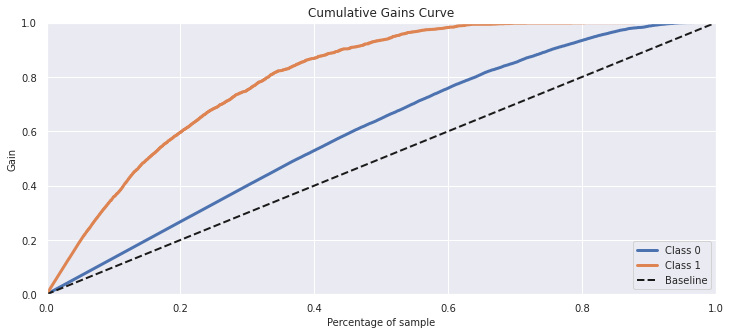

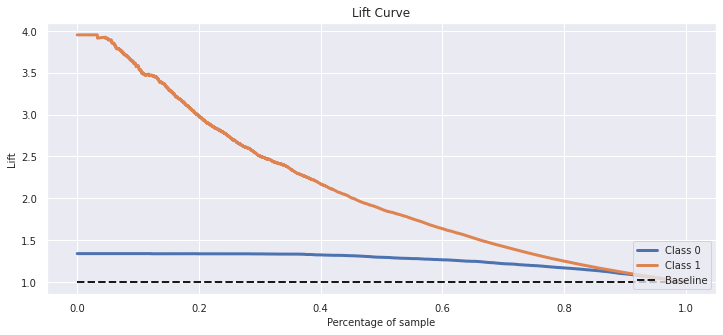

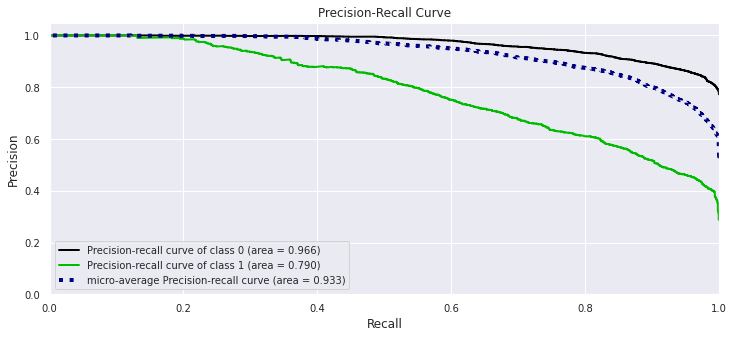

In [24]:
rfc_test = rfc.predict_proba(X_test)

skplt.metrics.plot_cumulative_gain(y_test, rfc_test, figsize=(12,5))
skplt.metrics.plot_lift_curve(y_test, rfc_test, figsize=(12,5))

skplt.metrics.plot_precision_recall_curve(y_test, rfc_test, figsize=(12,5))

# Support Vector Machine

Accuracy for rbf SVM is  0.8662357036300348
[[4340  167]
 [ 746  780]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4507
           1       0.82      0.51      0.63      1526

    accuracy                           0.85      6033
   macro avg       0.84      0.74      0.77      6033
weighted avg       0.85      0.85      0.84      6033



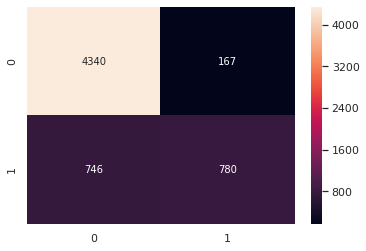

In [27]:
# SVM model with parameters from GridSearchCV
svm_rbf = svm.SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

svm_rbf.fit(X_train,y_train)
prediction1 = svm_rbf.predict(X_test)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,y_test))
print(confusion_matrix(y_test,prediction))
print(classification_report(y_test,prediction))

sns.heatmap(confusion_matrix(y_test,prediction),annot=True, fmt="d")


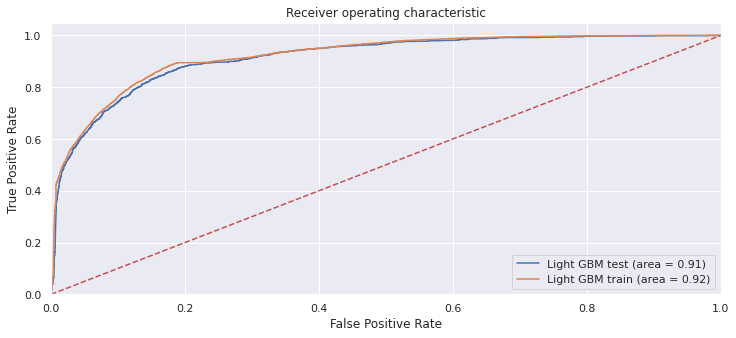

In [22]:
svm_rbf_train = svm_rbf.predict_proba(X_train)
svm_rbf_train = svm_rbf_train[:, 1]

svm_rbf = svm_rbf.predict_proba(X_test)
svm_rbf = svm_rbf[:, 1]

# y_test
plot_roc_auc(y_train, y_test,svm_rbf_train,svm_rbf)

/home/serena/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


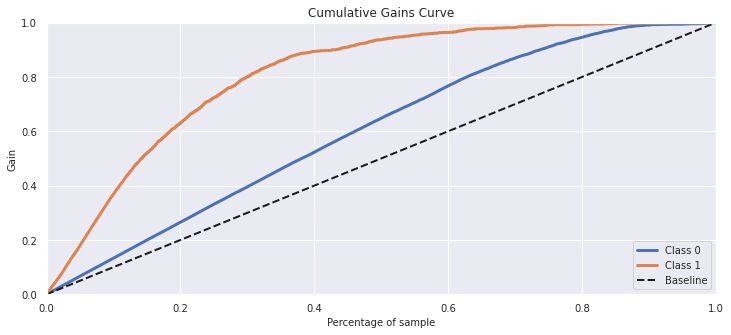

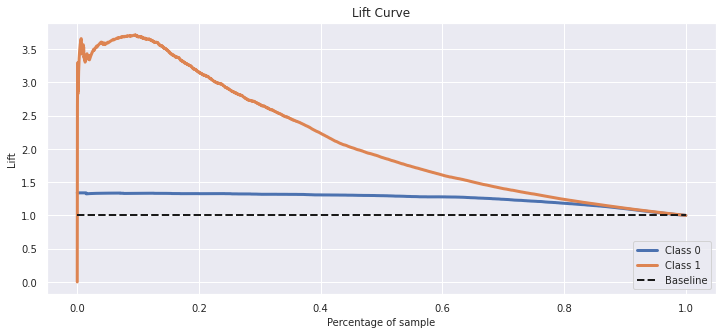

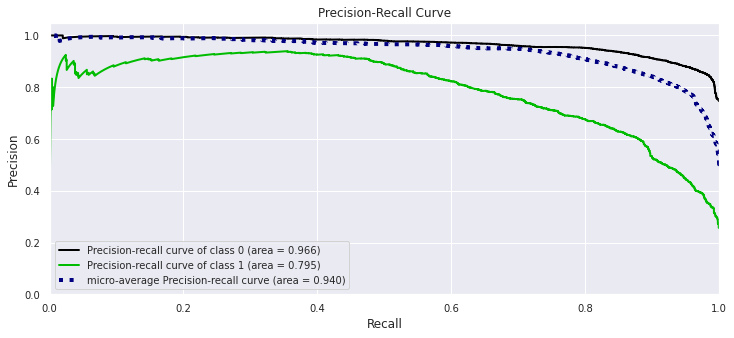

In [28]:
svm_rbf_test = svm_rbf.predict_proba(X_test)

skplt.metrics.plot_cumulative_gain(y_test, svm_rbf_test, figsize=(12,5))
skplt.metrics.plot_lift_curve(y_test, svm_rbf_test, figsize=(12,5))
skplt.metrics.plot_precision_recall_curve(y_test, svm_rbf_test, figsize=(12,5))